In [10]:
import kagglehub
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

In [11]:
path = kagglehub.dataset_download("landlord/handwriting-recognition")


In [12]:

def preprocess_image(image_path, target_size=(224, 224)):
    """Advanced image preprocessing with multiple fallback strategies"""
    try:
        # Read image with cv2 for better handling
        img_cv2 = cv2.imread(image_path)
        if img_cv2 is None:
            # Fallback to PIL
            img_pil = Image.open(image_path)
            img_cv2 = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

        # Convert to grayscale
        gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)

        # Apply preprocessing techniques
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)

        # Adaptive thresholding
        binary = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        # Convert to PIL and resize
        pil_img = Image.fromarray(cleaned)
        resized = resize_with_padding(pil_img, target_size)

        # Convert to RGB for model compatibility
        if resized.mode != 'RGB':
            resized = resized.convert('RGB')

        return resized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return Image.new('RGB', target_size, (255, 255, 255))

def resize_with_padding(image, target_size, fill_color=255):
    """Resize image with padding to maintain aspect ratio"""
    target_width, target_height = target_size
    original_width, original_height = image.size

    # Calculate scaling factor
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize image
    resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create new image with padding
    new_image = Image.new(image.mode, target_size, fill_color)
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized, (paste_x, paste_y))

    return new_image

In [13]:
class HandwritingLabelEncoder:
    """Enhanced label encoder with vocabulary pruning and class balancing"""

    def __init__(self, min_samples=5, max_classes=1000):
        self.encoder = LabelEncoder()
        self.min_samples = min_samples
        self.max_classes = max_classes
        self.fitted = False
        self.common_words = set()
        self.class_weights = None

    def load_csv_labels(self, csv_path):
        """Load and clean labels from CSV"""
        if not os.path.exists(csv_path):
            return {}

        try:
            df = pd.read_csv(csv_path)

            # Auto-detect columns
            filename_col = self._find_column(df, ['filename', 'image', 'file'])
            label_col = self._find_column(df, ['label', 'word', 'text', 'identity'])

            if filename_col is None:
                filename_col = df.columns[0]
            if label_col is None:
                label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

            # Create mapping with cleaning
            label_mapping = {}
            for _, row in df.iterrows():
                filename = str(row[filename_col]).strip()
                label = str(row[label_col]).strip().lower()

                # Skip invalid labels
                if label in ['nan', '', 'none', 'null']:
                    continue

                # Handle extensions
                for ext in ['.jpg', '.png', '.jpeg']:
                    if filename.endswith(ext):
                        label_mapping[filename] = label
                        break
                else:
                    # Add extension if missing
                    for ext in ['.jpg', '.png', '.jpeg']:
                        label_mapping[filename + ext] = label

            return label_mapping

        except Exception as e:
            print(f"Error loading CSV {csv_path}: {e}")
            return {}

    def _find_column(self, df, keywords):
        """Find column containing any of the keywords"""
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                return col
        return None

    def get_labels_from_folder_and_csv(self, folder_path, csv_path):
        """Extract labels from folder using CSV mapping"""
        if not os.path.exists(folder_path):
            return [], []

        csv_labels = self.load_csv_labels(csv_path)
        labels, filenames = [], []

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                if filename in csv_labels:
                    labels.append(csv_labels[filename])
                    filenames.append(filename)

        return labels, filenames

    def fit_transform_all(self, folder_csv_pairs):
        """Fit encoder and return processed data for all splits"""
        # Collect all labels
        all_labels = []
        all_data = {}

        for split_name, (folder_path, csv_path) in folder_csv_pairs.items():
            labels, filenames = self.get_labels_from_folder_and_csv(folder_path, csv_path)
            all_labels.extend(labels)
            all_data[split_name] = (labels, filenames, folder_path)

        if not all_labels:
            print("No labels found!")
            return {}, self

        # Filter vocabulary
        label_counts = Counter(all_labels)
        sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

        # Apply constraints
        valid_labels = []
        for label, count in sorted_labels:
            if count >= self.min_samples and len(valid_labels) < self.max_classes:
                valid_labels.append(label)

        self.common_words = set(valid_labels)

        if not self.common_words:
            print("No valid words found after filtering!")
            return {}, self

        # Fit encoder
        self.encoder.fit(list(self.common_words))
        self.fitted = True

        # Calculate class weights
        filtered_counts = {label: label_counts[label] for label in self.common_words}
        total_samples = sum(filtered_counts.values())
        self.class_weights = torch.tensor([
            total_samples / (len(self.common_words) * filtered_counts[label])
            for label in self.encoder.classes_
        ], dtype=torch.float)

        print(f"Vocabulary: {len(self.common_words)} words")
        print(f"Total samples: {total_samples}")
        print(f"Sample words: {list(self.common_words)[:10]}")

        # Transform all splits
        results = {}
        for split_name, (labels, filenames, folder_path) in all_data.items():
            encoded, filtered_filenames = self.transform_labels(labels, filenames)
            results[split_name] = {
                'labels': encoded,
                'filenames': filtered_filenames,
                'folder_path': folder_path
            }
            print(f"{split_name}: {len(encoded)} samples")

        return results, self

    def transform_labels(self, labels, filenames):
        """Transform labels and filter based on vocabulary"""
        if not self.fitted:
            raise ValueError("Encoder not fitted!")

        filtered_labels = []
        filtered_filenames = []

        for label, filename in zip(labels, filenames):
            if label in self.common_words:
                filtered_labels.append(label)
                filtered_filenames.append(filename)

        encoded = self.encoder.transform(filtered_labels) if filtered_labels else []
        return encoded, filtered_filenames


In [14]:
class HandwritingDataset(Dataset):
    """Enhanced dataset with better augmentations and error handling"""

    def __init__(self, folder_path, labels, filenames, transform=None, is_training=False):
        self.folder_path = folder_path
        self.labels = labels
        self.filenames = filenames
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.filenames[idx])

        try:
            image = preprocess_image(img_path, target_size=(224, 224))

            # Apply transforms
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations transform
                    image_np = np.array(image)
                    transformed = self.transform(image=image_np)
                    image = transformed['image']
                else:
                    # Torchvision transform
                    image = self.transform(image)
            else:
                # Default transform
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])
                ])
                image = transform(image)

            label = self.labels[idx]
            return image, label

        except Exception as e:
            # Return dummy data on error
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, 0

In [15]:
def get_transforms():
    """Get advanced augmentation transforms using Albumentations"""
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.OneOf([
            A.GaussNoise(var_limit=(10, 50), p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),
            A.MotionBlur(blur_limit=7, p=0.3),
        ], p=0.4),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
        ], p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10,
                          border_mode=cv2.BORDER_CONSTANT, value=255, p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
            A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.3),
        ], p=0.3),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16,
                       min_holes=1, min_height=4, min_width=4,
                       fill_value=255, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    return train_transform, val_transform

In [16]:
class EfficientNetCNN(nn.Module):
    """Improved CNN with EfficientNet backbone"""

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        # EfficientNet-B0 backbone
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # Advanced classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize classifier weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

class SpatialAttentionNet(nn.Module):

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        # Backbone
        self.backbone = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Spatial attention
        self.attention = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )

        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        attention_weights = self.attention(features)
        attended_features = features * attention_weights
        pooled = self.global_pool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        return self.classifier(pooled)


In [17]:

class ModelTrainer:
    """Advanced model trainer with better optimization strategies"""

    def __init__(self, model, train_loader, val_loader, num_classes, class_weights=None, device=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_classes = num_classes
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Move model to device
        self.model = self.model.to(self.device)

        # Loss function with class weights
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

        # Advanced optimizer
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=1e-3,
            weight_decay=1e-4,
            betas=(0.9, 0.999)
        )

        # Learning rate scheduler
        total_steps = len(train_loader) * 20
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=1e-3,
            total_steps=total_steps,
            pct_start=0.1,
            anneal_strategy='cos'
        )

        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        self.best_val_acc = 0.0

    def train_epoch(self):
        """Train one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()
            self.scheduler.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.3f}',
                'Acc': f'{100.*correct/total:.1f}%',
                'LR': f'{self.scheduler.get_last_lr()[0]:.6f}'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """Validate one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Validation'):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def train(self, num_epochs=20, save_path='best_model.pth'):
        """Train the model"""
        print(f"Training on {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Classes: {self.num_classes}")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            if self.val_loader is not None:
                val_loss, val_acc = self.validate_epoch()

                # Save history
                self.history['train_loss'].append(train_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)

                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                # Save best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    torch.save(self.model.state_dict(), save_path)
                    print(f"New best model saved! Val Acc: {val_acc:.2f}%")

                # Early stopping
                if val_acc > 90.0:
                    print("Early stopping - high accuracy reached!")
                    break
            else:
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        return self.model



Dataset path: /kaggle/input/handwriting-recognition

Processing labels...
Vocabulary: 500 words
Total samples: 155666
Sample words: ['nino', 'aymeric', 'bryan', 'leon', 'guilhem', 'gregoire', 'ilan', 'ewan', 'clea', 'brun']
train: 124582 samples
val: 15510 samples
test: 15574 samples


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Creating datasets...
train: 124582 samples
val: 15510 samples
test: 15574 samples

Creating model...


100%|██████████| 20.5M/20.5M [00:00<00:00, 226MB/s]


Using Improved CNN for large vocabulary

Starting training...
Training on cuda
Model parameters: 4,924,784
Classes: 500

Epoch 1/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:58<00:00,  4.16it/s]


Train Loss: 6.1361, Train Acc: 0.31%
Val Loss: 6.4216, Val Acc: 0.28%
New best model saved! Val Acc: 0.28%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.65it/s]


Train Loss: 5.0842, Train Acc: 1.97%
Val Loss: 5.8286, Val Acc: 0.96%
New best model saved! Val Acc: 0.96%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.62it/s]


Train Loss: 4.6620, Train Acc: 4.13%
Val Loss: 5.2895, Val Acc: 3.24%
New best model saved! Val Acc: 3.24%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:54<00:00,  4.46it/s]


Train Loss: 4.1095, Train Acc: 10.70%
Val Loss: 4.6318, Val Acc: 8.37%
New best model saved! Val Acc: 8.37%

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.65it/s]


Train Loss: 3.7387, Train Acc: 17.30%
Val Loss: 4.3156, Val Acc: 13.28%
New best model saved! Val Acc: 13.28%

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:51<00:00,  4.70it/s]


Train Loss: 3.5074, Train Acc: 21.69%
Val Loss: 4.1319, Val Acc: 16.93%
New best model saved! Val Acc: 16.93%

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:51<00:00,  4.69it/s]


Train Loss: 3.3441, Train Acc: 25.56%
Val Loss: 3.9190, Val Acc: 21.56%
New best model saved! Val Acc: 21.56%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.64it/s]


Train Loss: 3.1855, Train Acc: 29.59%
Val Loss: 3.7884, Val Acc: 25.51%
New best model saved! Val Acc: 25.51%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.66it/s]


Train Loss: 3.0467, Train Acc: 33.59%
Val Loss: 3.6466, Val Acc: 29.68%
New best model saved! Val Acc: 29.68%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.65it/s]


Train Loss: 2.9086, Train Acc: 37.55%
Val Loss: 3.5036, Val Acc: 34.53%
New best model saved! Val Acc: 34.53%

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.66it/s]


Train Loss: 2.7998, Train Acc: 40.84%
Val Loss: 3.4038, Val Acc: 37.12%
New best model saved! Val Acc: 37.12%

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.66it/s]


Train Loss: 2.7072, Train Acc: 43.29%
Val Loss: 3.3357, Val Acc: 39.78%
New best model saved! Val Acc: 39.78%

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:52<00:00,  4.61it/s]


Train Loss: 2.6184, Train Acc: 45.69%
Val Loss: 3.2721, Val Acc: 41.62%
New best model saved! Val Acc: 41.62%

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:51<00:00,  4.69it/s]


Train Loss: 2.5532, Train Acc: 47.42%
Val Loss: 3.2280, Val Acc: 43.12%
New best model saved! Val Acc: 43.12%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 243/243 [00:51<00:00,  4.69it/s]


Train Loss: 2.4948, Train Acc: 48.93%
Val Loss: 3.1844, Val Acc: 44.71%
New best model saved! Val Acc: 44.71%


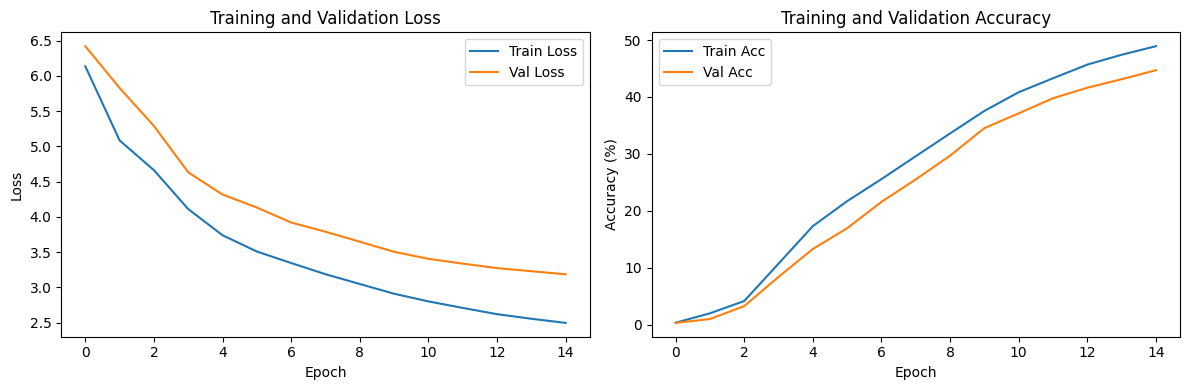


Training completed!
Best validation accuracy: 44.71%
Model saved as: improved_handwriting_model.pth
Encoder saved as: improved_encoder.pkl


In [18]:

def main():
    """Main training pipeline"""
    # Download dataset
    print("Downloading dataset...")
    base_path = kagglehub.dataset_download("landlord/handwriting-recognition")
    print(f"Dataset path: {base_path}")

    # Define data splits
    folder_csv_pairs = {
        'train': (
            os.path.join(base_path, 'train_v2/train'),
            os.path.join(base_path, 'written_name_train_v2.csv')
        ),
        'val': (
            os.path.join(base_path, 'validation_v2/validation'),
            os.path.join(base_path, 'written_name_validation_v2.csv')
        ),
        'test': (
            os.path.join(base_path, 'test_v2/test'),
            os.path.join(base_path, 'written_name_test_v2.csv')
        )
    }

    # Process labels
    print("\nProcessing labels...")
    encoder = HandwritingLabelEncoder(min_samples=10, max_classes=500)
    results, encoder = encoder.fit_transform_all(folder_csv_pairs)

    if not encoder.fitted or len(encoder.common_words) == 0:
        print("Error: No valid data found!")
        return

    # Save encoder
    with open('improved_encoder.pkl', 'wb') as f:
        pickle.dump(encoder, f)

    # Get transforms
    train_transform, val_transform = get_transforms()

    # Create datasets and dataloaders
    print("\nCreating datasets...")
    datasets = {}
    dataloaders = {}

    for split in ['train', 'val', 'test']:
        if split in results and len(results[split]['labels']) > 0:
            transform = train_transform if split == 'train' else val_transform
            datasets[split] = HandwritingDataset(
                folder_path=results[split]['folder_path'],
                labels=results[split]['labels'],
                filenames=results[split]['filenames'],
                transform=transform,
                is_training=(split == 'train')
            )

            # Create dataloader
            if split == 'train':
                # Use weighted sampling for class balance
                labels = [int(label) for label in datasets[split].labels]
                class_counts = Counter(labels)
                weights = [1.0 / class_counts[label] for label in labels]
                sampler = WeightedRandomSampler(weights, len(weights))
                dataloaders[split] = DataLoader(
                    datasets[split], batch_size=64, sampler=sampler,
                    num_workers=4, pin_memory=True, drop_last=True
                )
            else:
                dataloaders[split] = DataLoader(
                    datasets[split], batch_size=64, shuffle=False,
                    num_workers=4, pin_memory=True
                )

            print(f"{split}: {len(datasets[split])} samples")

    # Create model
    print("\nCreating model...")
    num_classes = len(encoder.encoder.classes_)

    if num_classes < 100:
        model = SpatialAttentionNet(num_classes, dropout_rate=0.3)
        print("Using Attention CNN for small vocabulary")
    else:
        model = EfficientNetCNN(num_classes, dropout_rate=0.4)
        print("Using Improved CNN for large vocabulary")

    # Train model
    print("\nStarting training...")
    trainer = ModelTrainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders.get('val'),
        num_classes=num_classes,
        class_weights=encoder.class_weights
    )

    trained_model = trainer.train(num_epochs=15, save_path='improved_handwriting_model.pth')

    # Plot training history
    if trainer.val_loader is not None:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(trainer.history['train_loss'], label='Train Loss')
        plt.plot(trainer.history['val_loss'], label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(trainer.history['train_acc'], label='Train Acc')
        plt.plot(trainer.history['val_acc'], label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")
    print(f"Model saved as: improved_handwriting_model.pth")
    print(f"Encoder saved as: improved_encoder.pkl")

if __name__ == "__main__":
    main()